# Full Dataset and Performance Analysis

This notebook contains some notes on the full extraction process and quality checks and metrics on the results

Before delving into the analysis a couple of remarks:

1) The final dataset I produced contains results for 561,794 10Qs from 1994 - 2010.  Running multiprocess jobs on my personal computer and several remote servers, I was able to produce this in roughly 1-2 days.  

2) Throughout the full time period of study, the composition of 10-Q filings changes from primarily text-based, to HTML, to xbrl submissions.  The shifting dynamics of filing behavior has a confounding effect when attempting to analyze extracted debt-levels over time as the application employs different strategies to extract information from each of these filing types with differing levels of accuracy and success.  **One significant challenge is the tendency for different filing types to use different units when reporting debt levels.**  Analyzing the data reveals that the debt levels obtained for text and HTML submissions are on average about two orders of magnitude less than those obtained for xbrl submissions.  This is likely explained by the tendency for text and HTML filings to report results in thousands or millions, contra xbrl filings which typically report results to the dollar level.  Resolving this sort of unit ambiguity is an area I'd like to improve upon given more time.

3)  There were several quarters for which the daily index files hosted by Edgar were tar-zipped.  Given the time constraints of the project I elected to exclude such index files from analysis.  Consequently, there are several quarters in the time period of study for which no information is obtained.

### Imports

In [48]:
import sys
sys.path.append("../") #make sure root edgarScraper directory is on pythonpath
from edgarScraper.edgarDebtScraper import EdgarDebtScraper

import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  
pd.options.display.max_columns = 99

### Read in the Full Dataset from the data directory.

In [4]:
# must specify path to data directory.  This must be set by user
DATA_DIR = '/home/peter/citadel/edgarScraper/data'

def read_in_data():

    dfs = []
    for year in range(1994, 2019):
        fileName = 'results_{}.csv'.format(year)
        filePath = os.path.join(DATA_DIR, fileName)
        dfs.append(pd.read_csv(filePath))

    df = pd.concat(dfs)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.drop_duplicates(inplace=True)
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for c in [c for c in df.columns if df[c].dtype in numerics]:
        df[c] = df[c].abs()
        
    # if a company submitted multiple 10-Qs within the same calendar month - take only the last one.  
    #df = df.set_index(['DATE', 'CIK', 'NAME'])
    df = df.groupby([pd.Grouper(key='DATE', freq='M'), 'CIK']).last()
    df = df.reset_index()

    return df

df = read_in_data()

In [31]:
#take a look at the head of the data frame.
df.head().set_index(['DATE', 'CIK', 'NAME'])

ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT  \
DATE       CIK    NAME                                                                               
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC                                     498811.0   
           70033  NATIONAL DATA CORP                                                       27292.0   
           861439 AMERICAN MEDICAL HOLDINGS INC                                                NaN   
1994-02-28 20290  CINCINNATI GAS & ELECTRIC CO                                         114952922.0   
           67887  MOOG INC                                                                  4539.0   

                                                       ACCOUNTSPAYABLECURRENT  \
DATE       CIK    NAME                                                          
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC                498811.0   
           70033  NATIONAL DATA CORP                                   5879.0   
           861439 AMERICAN MEDICAL HOLDINGS INC                           NaN   
1994-02-28 20290  CINCINNATI GAS & ELECTRIC CO                    114917924.0   
           67887  MOOG INC                                            12326.0   

                                                       ACCOUNTSPAYABLEOTHERCURRENT  \
DATE       CIK    NAME                                                               
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC                          NaN   
           70033  NATIONAL DATA CORP                                           NaN   
           861439 AMERICAN MEDICAL HOLDINGS INC                                NaN   
1994-02-28 20290  CINCINNATI GAS & ELECTRIC CO                                 NaN   
           67887  MOOG INC                                                     NaN   

                                                       ACCOUNTSPAYABLERELATEDPARTIESCURRENT  \
DATE       CIK    NAME                                                                        
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC                                   NaN   
           70033  NATIONAL DATA CORP                                                    NaN   
           861439 AMERICAN MEDICAL HOLDINGS INC                                         NaN   
1994-02-28 20290  CINCINNATI GAS & ELECTRIC CO                                      34998.0   
           67887  MOOG INC                                                              NaN   

                                                       ACCOUNTSPAYABLETRADECURRENT  \
DATE       CIK    NAME                                                               
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC                          NaN   
           70033  NATIONAL DATA CORP                                           NaN   
           861439 AMERICAN MEDICAL HOLDINGS INC                                NaN   
1994-02-28 20290  CINCINNATI GAS & ELECTRIC CO                                 NaN   
           67887  MOOG INC                                                     NaN   

                                                       ACCRUEDLIABILITIESCURRENT  \
DATE       CIK    NAME                                                             
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC                        NaN   
           70033  NATIONAL DATA CORP                                      4935.0   
           861439 AMERICAN MEDICAL HOLDINGS INC                              NaN   
1994-02-28 20290  CINCINNATI GAS & ELECTRIC CO                               NaN   
           67887  MOOG INC                                                   NaN   

                                                       BANKOVERDRAFTS  \
DATE       CIK    NAME                                                  
1994-01-31 43300  GREAT ATLANTIC & PACIFIC TEA CO INC             NaN   
           70033  NATIONAL DATA CORP                              NaN   
           861439 A

### Examine Counts obtained by Quarter

The plot below shows counts obtained for 10-Qs processed per quarter, broken down by filing type.  Three observations are worth mentioning:

1) There's a clear shift in submission type.  From 1994-2003 it's majority text documents, from 2003-2012 HTML dominates, and then post 2012 xbrl is the most frequent.  

2) It's apparent that there's a strong seasonal effect where counts obtained during the first quarter of a year are significantly less than the other three quarters.  It's possible that this is a result of companies "pre-filing" their first quarter 10Q's during the 4th Quarter of the previous year.

3) The orange bars in the chart below represent the counts for which extraction of any debt-level failed, and neither a final short or long term result is returned.  Extraction failure is slightly more likely for text documents, then for HTML or xbrl documents, which aligns with general expectations that information retrieval is easier with increasingly structured submission formats.

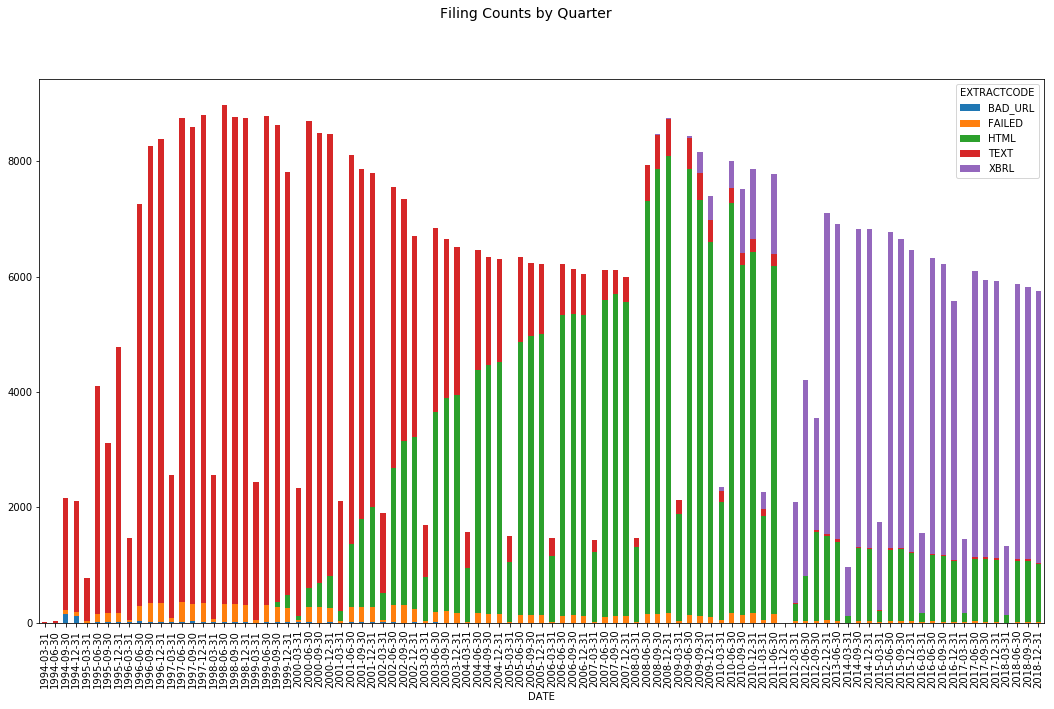

In [32]:
fig, ax = plt.subplots(figsize=(18,10))
countsByQuarter = df.groupby([pd.Grouper(key='DATE', freq='Q'), 'EXTRACTCODE'])["CIK"].count().unstack().fillna(0)
ax = countsByQuarter.plot(kind='bar', stacked=True, ax=ax)
_ = ax.set_xticklabels(countsByQuarter.index.format())
_ = fig.suptitle('Filing Counts by Quarter', fontsize=14)

### Extraction Performance Measures

To evaluate the performance of the application, I choose to examine the percentage of filings for which a final short or long term debt level was returned.  The chart below shows this for all filings, as well as, text, HTML, and xbrl filings only.

Overall, I was pleased with these results.  On average short-term debt levels were resolved for about 90% of all filings.  Long term debt-levels were obtained for about 70% of all filings.  When considering these results and accompanying charts, it's worth keeping two points in mind:

1) It's unclear what the true upper bound on extraction rates should be.  Occasionally filings listed in the daily index files return non-200 response codes when requested.  Other filings exist, but appear to have been submitted in error as they contain no financial information.  

2) A limiting factor of the design of my application is that it relies upon a variety of regex and fuzzy matching strategies in order to produce the final parsed results.  Essentially, this approach seeks to generalize from observed "canonical forms" of debt representation.  However, since accounting practices and terminology change with time, it's likely I failed to completely capture all necessary canonical forms.  To take an example - the performance of the long term debt extraction for XBRL documents shows a pronounced drop off post 2012.  One possible explanation is that the format of the us-gaap XBRL taxonomies used by filers was updated or modified during this year.  Since the extraction process makes use of standardized XBRL element tag names, this change in representation could account for the drop off in performance.  

Finally, it's worth mentioning that the analysis conducted here focuses on how successful extraction is at populating data elements.  It does not assess the accuracy of the actual values produced.  Given more time, it would be worth sampling a small set of filings and manually evaluating debt levels and comparing these values to the one's produced by the application.

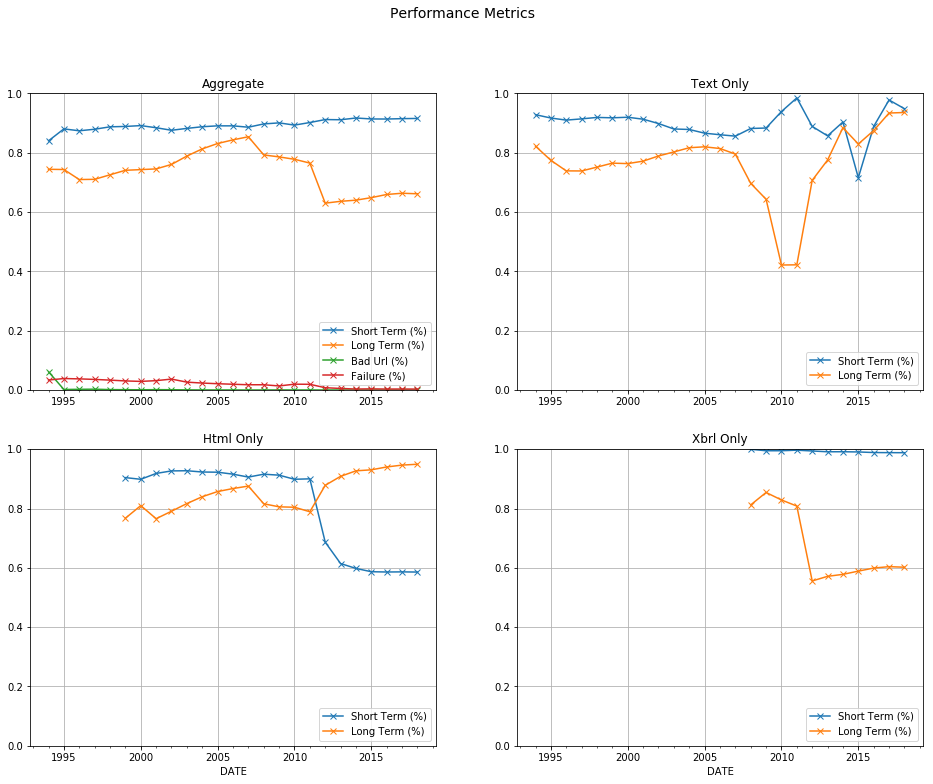

In [38]:
def getAggregatePerformanceStats(df):
    countsByQuarter = df.groupby(
        [pd.Grouper(key='DATE', freq='Y'), 'EXTRACTCODE']
    )['FINALSHORTTERM', 'FINALLONGTERM', 'CIK'].count().unstack()

    total = countsByQuarter['CIK'].sum(axis=1)
    total.name = "Total Count"
    totalShortTerm = countsByQuarter['FINALSHORTTERM'].sum(axis=1).div(total)
    totalShortTerm.name = "Short Term (%)"
    totalLongTerm = countsByQuarter['FINALLONGTERM'].sum(axis=1).div(total)
    totalLongTerm.name = "Long Term (%)"
    totalBadUrls = countsByQuarter['CIK']['BAD_URL'].div(total)
    totalBadUrls.name = "Bad Url (%)"
    totalFails = countsByQuarter['CIK']['FAILED'].div(total)
    totalFails.name = "Failure (%)"
    results = pd.concat([totalShortTerm, totalLongTerm, totalBadUrls, totalFails], axis=1).fillna(0)
    return results

def getStatsForExtractCode(df):
    countsByQuarter = df.groupby(
        pd.Grouper(key='DATE', freq='Y')
    )['FINALSHORTTERM', 'FINALLONGTERM', 'CIK'].count()
    total = countsByQuarter['CIK']
    totalShortTerm = countsByQuarter['FINALSHORTTERM'].div(total)
    totalShortTerm.name = "Short Term (%)"  
    totalLongTerm = countsByQuarter['FINALLONGTERM'].div(total)
    totalLongTerm.name = "Long Term (%)"
    results = pd.concat([totalShortTerm, totalLongTerm], axis=1).fillna(0)
    return results

def makePerformanceChart(df):
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(16,12))
    aggResults = getAggregatePerformanceStats(df)
    textResults = getStatsForExtractCode(df[df['EXTRACTCODE'] == 'TEXT'])
    htmlResults = getStatsForExtractCode(df[df['EXTRACTCODE'] == 'HTML'])
    xbrlResults = getStatsForExtractCode(df[df['EXTRACTCODE'] == 'XBRL'])
    ax1 = aggResults.plot(ax=ax1, marker='x')
    ax1.set_title('Aggregate')
    ax1.legend(loc='lower right')
    ax1.grid()

    ax2 = textResults.plot(ax=ax2, marker='x')
    ax2.set_title('Text Only')
    ax2.legend(loc='lower right')
    ax2.grid()

    ax3 = htmlResults.plot(ax=ax3, marker='x')
    ax3.set_title('Html Only')
    ax3.legend(loc='lower right')
    ax3.grid()

    ax4 = xbrlResults.plot(ax=ax4, marker='x')
    ax4.set_title('Xbrl Only')
    ax4.legend(loc='lower right')
    ax4.grid()
    
    ylims = (0,1)
    ax1.set_ylim(ylims)
    ax2.set_ylim(ylims)
    ax3.set_ylim(ylims)
    ax4.set_ylim(ylims)
    
    ax2.set_xlim(ax1.get_xlim())
    ax3.set_xlim(ax1.get_xlim())
    ax4.set_xlim(ax1.get_xlim())
    
    x_label = ax1.axes.get_xaxis().get_label()
    x_label.set_visible(False)
    
    x_label = ax2.axes.get_xaxis().get_label()
    x_label.set_visible(False)
    
    fig.suptitle('Performance Metrics', fontsize=14)
    

makePerformanceChart(df)

### Population Frequencies by Field Type

It's worth looking at how frequently individual fields are populated.  Below, frequencies for the top 20 most commonly extracted fields are plotted.

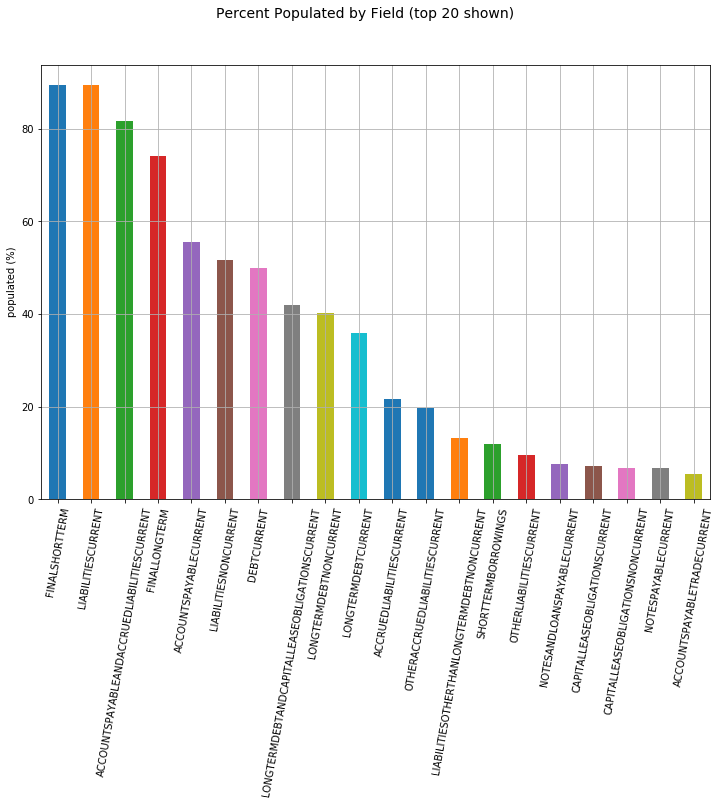

In [28]:
def makePopulatedCounts(df, name):

    s = 100*(~pd.isnull(df)).sum(axis=0) / df.shape[0]
    s.drop(['CIK', 'NAME', 'EXTRACTCODE'], inplace=True)
    s.name = name
    return s

def makePopulatedPlot(df):
    fig, ax1 = plt.subplots(figsize=(12,8))
    
    total = df.set_index('DATE')
    totalPops = makePopulatedCounts(total, '1994 - 2019')
    totalPops.sort_values(ascending=False, inplace=True)
    top = totalPops.iloc[:20]
    
    top.plot.bar(ax=ax1, rot=80)
    ax1.grid()
    ax1.set_ylabel('populated (%)')

    fig.suptitle('Percent Populated by Field (top 20 shown)', fontsize=14)

    
makePopulatedPlot(df)